In [1]:
import streamlit as st
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

!pip install google_play_scraper
from google_play_scraper import reviews_all, Sort

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
## for text processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
## for sentiment
!pip install textblob
from textblob import TextBlob
## for vectorizer
from sklearn import feature_extraction, manifold

##Predict
!pip install transformers
from transformers import RobertaForSequenceClassification, AutoTokenizer

from transformers import logging

!pip install torch
import torch


2023-01-10 13:46:30.390 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muarrikh.yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muarrikh.yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muarrikh.yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
app_package_name = 'com.netflix.ninja'

result = reviews_all(
    app_package_name,
    sleep_milliseconds=2, # defaults to 0
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [3]:
len(result)

328

In [4]:
df_raw = pd.DataFrame.from_records(result)

In [5]:
# df_raw = pd.read_excel(r'D:\Portfolio\Dataset\Chat_Team_CaseStudy FINAL.xlsx')

In [6]:
df = df_raw.copy()

In [7]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,2caceb01-d089-40eb-92cc-bc7eefbd2c26,Saoirse Kelly,https://play-lh.googleusercontent.com/a-/AD5-W...,Very difficult to navigate app on Chromecast a...,1,2,9.0.5 build 11217,2023-01-06 06:37:20,None,None
1,338fcd11-6a2d-476d-95da-bbdf66a51b46,N A,https://play-lh.googleusercontent.com/a-/AD5-W...,bloatware can't delete,1,0,8.3.2 build 4580,2023-01-02 02:22:49,None,None
2,d86ec456-93de-41bf-8eba-8bd28e5463d1,Pichon Snchz,https://play-lh.googleusercontent.com/a-/AD5-W...,does not support Xgimi in 4k,1,0,9.0.5 build 11217,2023-01-02 01:41:04,None,None
3,58051d10-0738-4dd1-91b5-55c5f8009f5e,Evan McGuire,https://play-lh.googleusercontent.com/a/AEdFTp...,app forever crashing,1,0,8.3.4 build 4625,2022-12-30 18:04:55,None,None
4,167d60d2-dbf3-4377-9307-a1aec3edc6e1,Vanathaian Johnpeter,https://play-lh.googleusercontent.com/a-/AD5-W...,very poor,1,0,None,2022-12-28 22:35:58,None,None


In [8]:
df.shape

(328, 10)

In [9]:
df.dtypes

reviewId                        object
userName                        object
userImage                       object
content                         object
score                            int64
thumbsUpCount                    int64
reviewCreatedVersion            object
at                      datetime64[ns]
replyContent                    object
repliedAt                       object
dtype: object

In [10]:
df.score.unique()

array([1, 2, 3, 5, 4], dtype=int64)

In [11]:
min(df['at'])

Timestamp('2014-07-26 15:54:17')

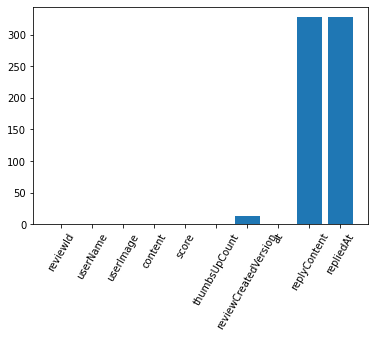

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion     13
at                        0
replyContent            328
repliedAt               328
dtype: int64

In [13]:
nans = df.isna().sum()
nans_x = nans.index.to_list()
nans_y = nans.values
plt.bar(nans_x, nans_y)
plt.xticks(rotation=60)
plt.show()
display(nans)

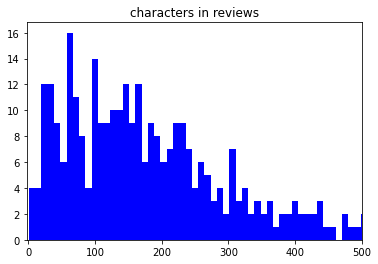

In [14]:
review_len=df['content'].str.len()
plt.hist(review_len,color='blue', bins=100)
plt.xlim(-2, 500)
plt.title('characters in reviews')
plt.show()

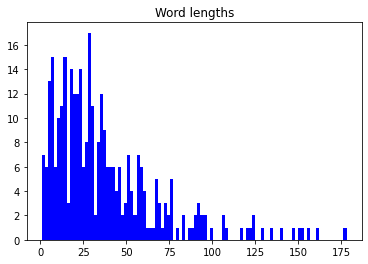

In [15]:
review_len=df['content'].str.split().map(lambda x: len(x))
plt.hist(review_len,color='blue', bins=100)
plt.title('Word lengths')
plt.show()

In [16]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [17]:
lst_stopwords = nltk.corpus.stopwords.words("english")
df['content_clean'] = df['content'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [18]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,content_clean
0,2caceb01-d089-40eb-92cc-bc7eefbd2c26,Saoirse Kelly,https://play-lh.googleusercontent.com/a-/AD5-W...,Very difficult to navigate app on Chromecast a...,1,2,9.0.5 build 11217,2023-01-06 06:37:20,None,None,difficult navigate app chromecast app phone ap...
1,338fcd11-6a2d-476d-95da-bbdf66a51b46,N A,https://play-lh.googleusercontent.com/a-/AD5-W...,bloatware can't delete,1,0,8.3.2 build 4580,2023-01-02 02:22:49,None,None,bloatware cant delete
2,d86ec456-93de-41bf-8eba-8bd28e5463d1,Pichon Snchz,https://play-lh.googleusercontent.com/a-/AD5-W...,does not support Xgimi in 4k,1,0,9.0.5 build 11217,2023-01-02 01:41:04,None,None,support xgimi 4k
3,58051d10-0738-4dd1-91b5-55c5f8009f5e,Evan McGuire,https://play-lh.googleusercontent.com/a/AEdFTp...,app forever crashing,1,0,8.3.4 build 4625,2022-12-30 18:04:55,None,None,app forever crashing
4,167d60d2-dbf3-4377-9307-a1aec3edc6e1,Vanathaian Johnpeter,https://play-lh.googleusercontent.com/a-/AD5-W...,very poor,1,0,None,2022-12-28 22:35:58,None,None,poor


In [19]:
def create_corpus():
    corpus = []
    for x in df['content_clean'].str.lower().str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus = create_corpus()

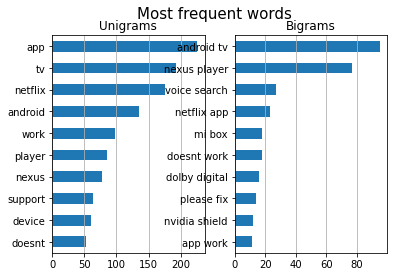

In [20]:
top=10
corpus = df["content_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
    
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

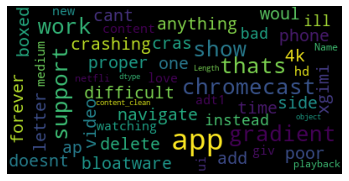

In [21]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

<h3>Modeling</h3>

In [22]:
idx_to_label = {
    0: 'CONTENT',
    1: 'USER_EXPERIENCE',
    2: 'SUBSCRIPTION',
    3: 'INTERFACE'}
idx_to_label_sentiments = {
    0: 'NEGATIVE',
    1: 'NEUTRAL',
    2: 'POSITIVE'
}

In [25]:
model = RobertaForSequenceClassification.from_pretrained('ArafatBHossain/bert-base_fine_tuned_app_reviews')

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

C:\Users\muarrikh.yazka\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\muarrikh.yazka\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models a

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at ArafatBHossain/bert-base_fine_tuned_app_reviews were not used when initializing RobertaForSequenceClassification: ['bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.2.attention.self.query.bias', 'bert.embeddings.LayerNorm.weight', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.2.output.dense.weight', 'bert.encoder.layer.2.attention.self.value.weight', 'bert.encoder.layer.8.attention.self.query.bias', 'bert.encoder.layer.1.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ArafatBHossain/bert-base_fine_tuned_app_reviews and are newly initialized: ['encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.4.attention.self.query.bias', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.bias', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.query.bias', 'encoder.layer.9.attention.output.LayerNorm.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.6.attention.output.dense.weight', 'encoder.layer.9.attention.self.value.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.5.attention.self.value.bias', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.2.intermediate.d